In [1]:
from binance.spot import Spot 
from sys import stderr
import sys, os,datetime,requests,json,pandas as pd,numpy as np
import time,math, gc

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn
from sklearn.model_selection import train_test_split
min_max_scaler = sklearn.preprocessing.MinMaxScaler()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [6]:
def import_api(time_last,symbol="BTCUSDT",limit=12*60):
    params={"symbol":symbol,"limit":limit,"interval":"5m","endTime":time_last,"startTime":(time_last-12*3600*1000)}
    r=requests.get(url="https://api.binance.com/api/v3/klines", params=params)
    df=pd.DataFrame(r.json())
    return df

In [7]:
def transform_df (df):
    column_names=['Open_time','Open','High','Low','Close','Volume','Close_time','Quote_asset_volume',
               'Number_of_trades','Taker_buy_base_asset_volume','Taker_buy_quote_asset_volume','Ignore']
    df=df.reset_index(drop=True)
    df.set_axis(column_names,axis=1,inplace=True)
    for col in df.columns:
        df[col] = df[col].astype(float)
    weekday=[]
    month=[]
    for i in range(df['Open'].size):
        dt_open=datetime.datetime.fromtimestamp(df['Open_time'][i]//1000)
        dt_close=datetime.datetime.fromtimestamp(df['Close_time'][i]//1000)
        df['Open_time'][i]=dt_open.hour*3600+dt_open.minute*60+dt_open.second
        df['Close_time'][i]=dt_close.hour*3600+dt_close.minute*60+dt_close.second
        weekday.append(dt_open.weekday())
        month.append(dt_open.month)
        #df['Open_time'][i]=dt_open.strftime("%I:%M:%S")
        #df['Close_time'][i]=dt_close.strftime("%I:%M:%S")
    df['weekday']=weekday
    df['month']=month
    df=df.drop(df.columns[[7,10,11,13]],axis=1)
    del(month)
    del(weekday)
    return df


In [8]:
def moving_average(data,range_):
    data_=[]
    mean=[]
    for i in range(range_):
        this_mean=0
        for j in range(i+1):
            this_mean+=data[j]
        mean.append(this_mean/(j+1))
    for i in range(range_,len(data)-1):
        this_mean=data[i]
        for j in range(1,range_):
            this_mean+=data[i-j]
        mean.append(this_mean/(range_))
    return mean

In [9]:
def generate_previous(df,count,col_name):
    #idxes=
    df=df.reset_index(drop=True)
    values=list(df[col_name][0:count])
    columns={}
    for i in range(count):
        this_name="prev_"+col_name+"_"+str(i+1)
        columns[this_name]=[]
    for i in range(count,df[col_name].size):
        for j in range(count):
            this_name="prev_"+col_name+"_"+str(j+1)
            columns[this_name].append(values[-(j+1)])
        values.pop(0)
        values.append(df[col_name][i])
    size=df[col_name].size
    df=df[count:size]
    for i in range(count):
        this_name="prev_"+col_name+"_"+str(i+1)
        df[this_name]=columns[this_name]
    
    return df.reset_index(drop=True)

In [109]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [a for a in (df.iloc[i:i+window_size].drop("target",axis=1).values)]
        X.append(row)
        label = df["target"][i+window_size-1]
        y.append(label)
    return np.array(X), np.array(y)

In [6]:
def import_api(time_last,symbol="BTCUSDT",limit=12*60):
    params={"symbol":symbol,"limit":limit,"interval":"1m","endTime":time_last,"startTime":(time_last-12*3600*1000)}
    r=requests.get(url="https://api.binance.com/api/v3/klines", params=params)
    df=pd.DataFrame(r.json())
    return df

In [7]:
def transform_df (df):
    column_names=['Open_time','Open','High','Low','Close','Volume','Close_time','Quote_asset_volume',
               'Number_of_trades','Taker_buy_base_asset_volume','Taker_buy_quote_asset_volume','Ignore']
    df=df.reset_index(drop=True)
    df.set_axis(column_names,axis=1,inplace=True)
    for col in df.columns:
        df[col] = df[col].astype(float)
    weekday=[]
    month=[]
    for i in range(df['Open'].size):
        dt_open=datetime.datetime.fromtimestamp(df['Open_time'][i]//1000)
        dt_close=datetime.datetime.fromtimestamp(df['Close_time'][i]//1000)
        df['Open_time'][i]=dt_open.hour*3600+dt_open.minute*60+dt_open.second
        df['Close_time'][i]=dt_close.hour*3600+dt_close.minute*60+dt_close.second
        weekday.append(dt_open.weekday())
        month.append(dt_open.month)
        #df['Open_time'][i]=dt_open.strftime("%I:%M:%S")
        #df['Close_time'][i]=dt_close.strftime("%I:%M:%S")
    df['weekday']=weekday
    df['month']=month
    df=df.drop(df.columns[[7,10,11,13]],axis=1)
    del(month)
    del(weekday)
    return df


In [8]:
def moving_average(data,range_):
    data_=[]
    mean=[]
    for i in range(range_):
        this_mean=0
        for j in range(i+1):
            this_mean+=data[j]
        mean.append(this_mean/(j+1))
    for i in range(range_,len(data)-1):
        this_mean=data[i]
        for j in range(1,range_):
            this_mean+=data[i-j]
        mean.append(this_mean/(range_))
    return mean

In [9]:
def generate_previous(df,count,col_name):
    #idxes=
    df=df.reset_index(drop=True)
    values=list(df[col_name][0:count])
    columns={}
    for i in range(count):
        this_name="prev_"+col_name+"_"+str(i+1)
        columns[this_name]=[]
    for i in range(count,df[col_name].size):
        for j in range(count):
            this_name="prev_"+col_name+"_"+str(j+1)
            columns[this_name].append(values[-(j+1)])
        values.pop(0)
        values.append(df[col_name][i])
    size=df[col_name].size
    df=df[count:size]
    for i in range(count):
        this_name="prev_"+col_name+"_"+str(i+1)
        df[this_name]=columns[this_name]
    
    return df.reset_index(drop=True)

In [5]:
directory=
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cuda:0


In [32]:
count=2*365
time_now=datetime.datetime.now()
time_now=round(time_now.timestamp())*1000
df=pd.DataFrame()
for i in range(2*365): #2*365
    df=import_api(time_now-12*3600*1000*i,'ETHUSDT').append(df)

In [33]:
df=transform_df(df)

In [62]:
target=[]
for i in range(df["Open"].size-5):
    target.append(df["Open"][i+4])
df=df[0:df["Open"].size-5]
df["target"]=target

In [34]:
df

,Open_time,Open,High,Low,Close,Volume,Close_time,Number_of_trades,Taker_buy_base_asset_volume,weekday
0,41400.0,3920.34,3934.41,3905.00,3919.28,6458.62081,41699.0,9014.0,4248.83966,3
1,41700.0,3919.13,3921.66,3904.24,3910.60,4226.49443,41999.0,8186.0,2206.58807,3
2,42000.0,3910.77,3919.00,3876.46,3878.59,7412.75654,42299.0,13475.0,3111.46300,3
3,42300.0,3878.60,3881.84,3850.00,3869.54,12355.76925,42599.0,20393.0,6367.42551,3
4,42600.0,3869.55,3892.15,3824.34,3833.52,13112.36213,42899.0,23461.0,6840.95372,3
...,...,...,...,...,...,...,...,...,...,...
105037,39900.0,2061.52,2069.87,2057.12,2058.94,3534.08560,40199.0,4557.0,1590.15710,4
105038,40200.0,2058.94,2064.65,2054.70,2063.62,2510.72300,40499.0,2761.0,1274.76190,4
105039,40500.0,2063.61,2067.20,2056.00,2064.88,2311.30210,40799.0,2882.0,1140.90420,4
105040,40800.0,2064.91,2067.44,2056.41,2066.63,2418.48530,41099.0,3064.0,1157.20450,4


<AxesSubplot:>

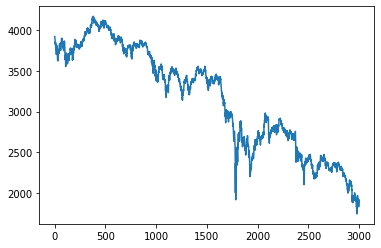

In [35]:
df["Open"][:3000].plot()

In [2]:
df.to_csv(directory+'\\eth_usdt_5min.csv',index=False)

In [61]:
df=pd.read_csv(r'G:\eth_usdt.csv')[50000:300000].reset_index(drop=True)

In [110]:
X,y=df_to_X_y(df)

In [43]:
df.head()

,Open_time,Open,High,Low,Close,Volume,Close_time,Number_of_trades,Taker_buy_base_asset_volume,weekday,target
0,60300.0,3060.85,3061.51,3055.20,3056.85,1775.8645,60359.0,1432.0,982.7525,1,3058.54
1,60360.0,3056.96,3060.83,3055.59,3056.53,806.2867,60419.0,1116.0,384.1670,1,3056.13
2,60420.0,3056.53,3064.55,3056.23,3061.63,1113.9758,60479.0,1316.0,674.6978,1,3061.15
3,60480.0,3061.63,3062.93,3058.31,3058.55,860.5544,60539.0,1099.0,387.8404,1,3057.67
4,60540.0,3058.54,3061.00,3056.00,3056.13,592.4771,60599.0,679.0,313.0345,1,3057.97
